In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import requests, io, cv2
import numpy as np
from tqdm.auto import tqdm
from PIL import Image

torch.__version__

'1.6.0'

In [71]:
model = torchvision.models.vgg19(pretrained=True, progress=True)
model = model.features[:]

In [72]:
def load_image(url):
    response = requests.get(url)
    bytes_im = io.BytesIO(response.content)
    return cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_BGR2BGRA)[...,:3] / 255


mean = np.array([0.485, 0.456, 0.406]) 
std = np.array([0.229, 0.224, 0.225])
normalize = transforms.Compose([transforms.Normalize(mean, std)])


def preprocess(img, scale=1):
    img = img[...,:3].transpose(2, 0, 1)
    img = normalize(torch.Tensor(img)).unsqueeze(dim=0)
    return img


def postprocess(img):
    img = img[0].permute(1, 2, 0)
    img = img.detach().cpu().numpy()
    img = img * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    return img.clip(0, 1)


def show_image(img):
    img = (img * 255).astype(np.uint8)
    return Image.fromarray(img)

In [73]:
the_girl = 'https://image.slidesharecdn.com/nationalgeographic50bestphotographs-130812140426-phpapp02/95/national-geographic-50-best-photographs-1-638.jpg?cb=1376401598'

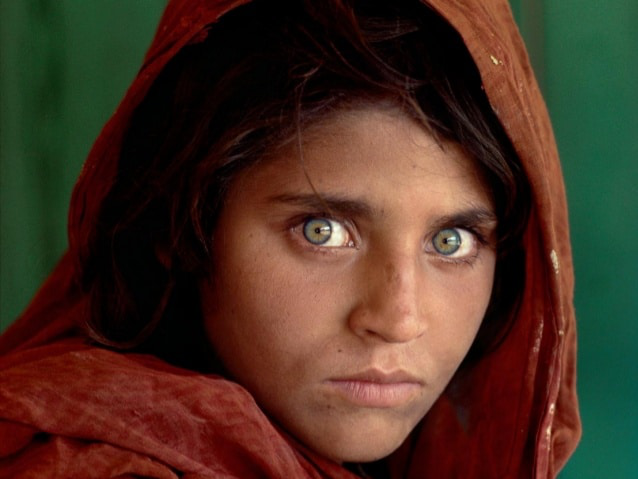

In [74]:
url = the_girl
np_im = load_image(url)
pil_im = show_image(np_im)
pil_im

In [75]:
n_im = preprocess(np_im)
n_im.shape, n_im.min(), n_im.max()

(torch.Size([1, 3, 479, 638]), tensor(-2.1179), tensor(2.3936))

In [76]:
i = postprocess(n_im)
i.shape, i.min(), i.max()

((479, 638, 3), 0.0, 0.9999999964237213)

In [92]:
def dream(model, inp, lr, its):
    model.train()

    for i in range(its):
        model.zero_grad()
        features = model(inp)
        norm = features.norm()
        norm.backward()

        mean_grad = inp.grad.abs().mean()
        detail = inp.grad.data / mean_grad * lr
        inp.data += detail
        inp.grad.zero_()

    return inp

In [93]:
DEVICE = 'cuda'

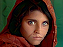

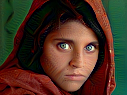

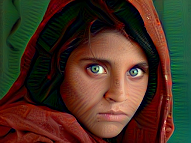

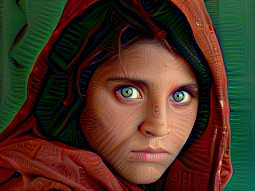

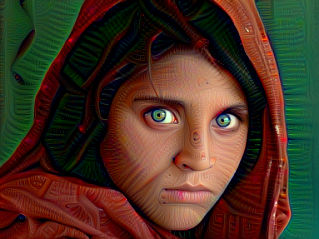

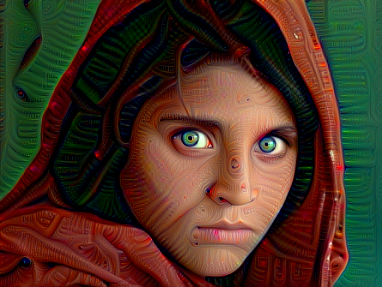

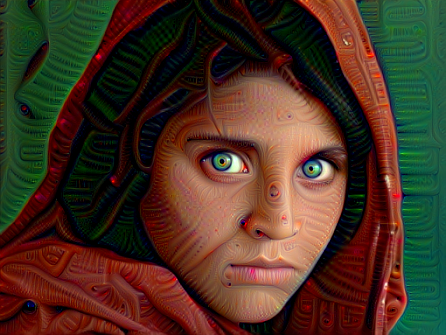

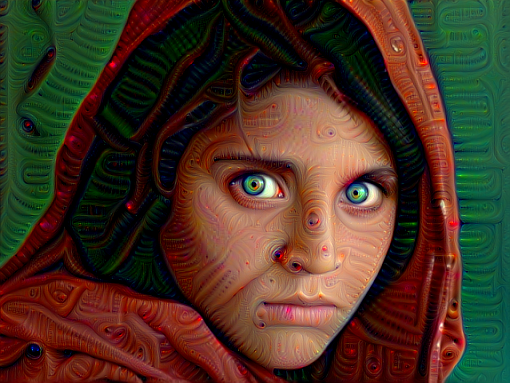

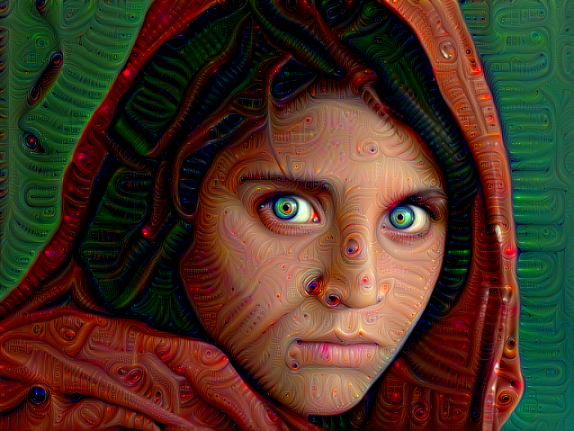

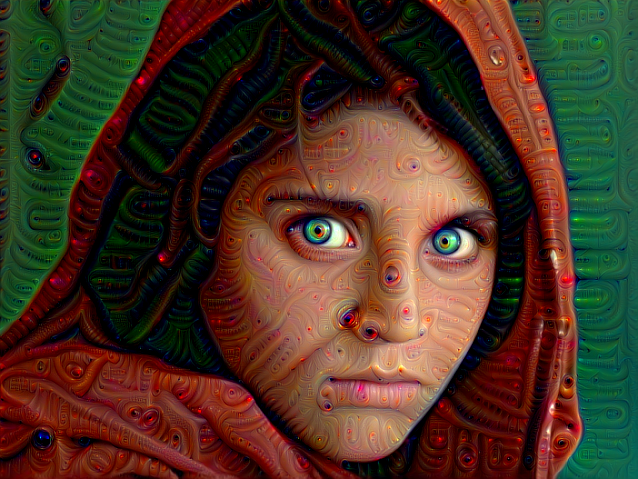

In [101]:
o_inp = preprocess(np_im).to(DEVICE)
model = model.to(DEVICE)
detail = torch.zeros_like(o_inp).to(DEVICE)

H, W = o_inp.shape[-2:]

steps = 10
for i in tqdm(range(steps)):
    scale = 0.1 + 0.9 * (i / (steps - 1))

    H_scale, W_scale = int(H * scale), int(W * scale)
    interp_inp = F.interpolate(o_inp, (H_scale, W_scale), mode='bilinear')
    detail = F.interpolate(detail, (H_scale, W_scale), mode='bilinear')
    inp = torch.autograd.Variable(interp_inp + detail, requires_grad=True)

    inp = dream(model[:11 + i], inp, lr=0.01, its=10)
    detail =  inp.data - interp_inp

    out = postprocess(interp_inp + detail)
    display(show_image(out))

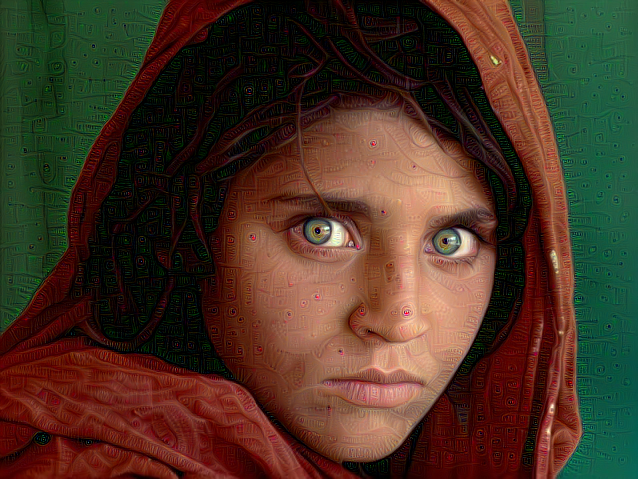

In [412]:
show_image(out)

In [133]:
inp.grad.min(), inp.grad.max()

(tensor(-4.8561), tensor(4.2753))